# Jaccard index implementation comparison

This is an attempt to compare two different methods of calculating the Jaccard index (direct set operations vs. iterating over underlying hashes/elements and counting to avoid some of the set operations).

In [1]:
import random
import pprint

from pyroaring import BitMap

num_hashes = 10
max_hash = 100
num_samples = 10
timing_repeats = 5
timing_iterations = 1000

def build_sample_hashes(num_samples, num_hashes, max_hash, num_fixed_hashes = 0):
    random.seed(42)
    
    num_random_hashes = num_hashes - num_fixed_hashes
    fixed_hashes = [x for x in range(num_fixed_hashes)]
    
    # Fixed hashes are numbers from 0 ... num_fixed_hashes - 1
    # Random hashes should not overlap fixed hashes, so set min of range for random selection here
    min_random_hashes_range = num_fixed_hashes + 1

    sample_hashes = {}
    for sample in range(num_samples):
        sample_hashes[sample] = BitMap(random.sample(range(min_random_hashes_range, max_hash), num_random_hashes))
        sample_hashes[sample].update(fixed_hashes)
    return sample_hashes

def build_hash_samples(sample_hashes):
    hash_samples = {}

    for s in sample_hashes:
        for h in sample_hashes[s]:
            if h not in hash_samples:
                hash_samples[h] = BitMap([s])
            else:
                hash_samples[h].add(s)
    return hash_samples

def build_data_structures(num_samples, num_hashes, max_hash, num_fixed_hashes = 0):
    sample_hashes = build_sample_hashes(num_samples=num_samples, num_hashes=num_hashes,
                                        max_hash=max_hash, num_fixed_hashes=num_fixed_hashes)
    hash_samples = build_hash_samples(sample_hashes)
    
    return {
        'sample_hashes': sample_hashes,
        'hash_samples': hash_samples
    }

# Build small data structure to show what it does
pprint.pprint(build_data_structures(num_samples=5, num_hashes=10, max_hash=max_hash, num_fixed_hashes=1))

# Build larger data structure to test below functions
data_structures = build_data_structures(num_samples=num_samples, num_hashes=num_hashes, max_hash=max_hash)

{'hash_samples': {0: BitMap([0, 1, 2, 3, 4]),
                  2: BitMap([3]),
                  5: BitMap([0, 1, 2]),
                  6: BitMap([1]),
                  13: BitMap([1, 4]),
                  15: BitMap([0, 4]),
                  16: BitMap([0]),
                  19: BitMap([0]),
                  21: BitMap([4]),
                  22: BitMap([3]),
                  27: BitMap([2]),
                  29: BitMap([1, 4]),
                  30: BitMap([0, 3]),
                  31: BitMap([2]),
                  33: BitMap([0]),
                  37: BitMap([0, 3, 4]),
                  45: BitMap([4]),
                  55: BitMap([3]),
                  56: BitMap([1, 4]),
                  59: BitMap([3]),
                  66: BitMap([2]),
                  71: BitMap([1, 3]),
                  73: BitMap([2]),
                  77: BitMap([1, 3]),
                  79: BitMap([2]),
                  83: BitMap([0]),
                  85: BitMap([2]),
              

Here, we have two data structures representing the same data:

1. `sample_hashes`: maps a sample (identified numerically starting from the 0th sample) to a set of hashes
    1. That is the data structure is like `{'sample_id' => set of hashes (as a bitmap)}`
2. `hash_samples`: maps a hash to a set of samples containing this hash.
    1. That is the data structure is like `{'hash' => set of samples (as a bitmap)}`

My goal is to test two different methods to measure the Jaccard distance using these two data structures to see how they perform.

I set a number of hashes (belonging to a sample) as fixed to simulate the situtation where (e.g., when doing MinHash of kmers) some samples share a certain kmer (hash) in common among them all.

Below I implement a wrapper to wrap functions with arguments for `timeit` (see https://www.pythoncentral.io/time-a-python-function/) and generate some stats for plotting.

In [24]:
import timeit
from statistics import mean, stdev, median, quantiles

def wrapper(func, *args, **kwargs):
    def wrapped():
        return func(*args, **kwargs)
    return wrapped

def stats(values):
    mn = mean(values)
    md = median(values)
    if len(values) > 1:
        sd = stdev(values)
    else:
        sd = 0
        
    return {
        'mean': mn,
        'median': md,
        'stdev': sd
    }

def do_timing(func, iterations, repeat, label):
    results = func()
    return_table = stats(timeit.repeat(func, number=iterations, repeat=repeat))
    return_table['results'] = results
    return_table['label'] = label
    return return_table

test_wrapper = wrapper(mean, range(1,100))
do_timing(test_wrapper, iterations=100, repeat=5, label='test')

{'mean': 0.0037830000001122244,
 'median': 0.0037210000009508803,
 'stdev': 0.0006093508555149945,
 'results': 50,
 'label': 'test'}

# Jaccard by iterating over samples

In [12]:
def regular_jaccard_index(query_sample, sample_hashes):
    jaccard_values = {}
    for s in sample_hashes:
        query_sample_hashes = sample_hashes[query_sample]
        comparison_sample_hashes = sample_hashes[s]

#         jaccard = len(query_sample_hashes & comparison_sample_hashes) / len(query_sample_hashes | comparison_sample_hashes)
        # Test out runtime when using pyroaring's built-in Jaccard distance calculation
        jaccard_values[s] = query_sample_hashes.jaccard_index(comparison_sample_hashes)
        
    return jaccard_values

regular_jaccard_index(query_sample=0, sample_hashes=data_structures['sample_hashes'])

{0: 1.0,
 1: 0.1111111111111111,
 2: 0.1111111111111111,
 3: 0.05263157894736842,
 4: 0.05263157894736842,
 5: 0.0,
 6: 0.0,
 7: 0.1111111111111111,
 8: 0.0,
 9: 0.1111111111111111}

# Jaccard index by iterating over hashes

In [13]:
def inverted_jaccard_index(query_sample, hash_samples, sample_hashes, num_samples, num_hashes):
    query_hashes = sample_hashes[query_sample]
    sample_hash_counts = {}
    for qh in query_hashes:
        for s in hash_samples[qh]:
            if s not in sample_hash_counts:
                sample_hash_counts[s] = 1
            else:
                sample_hash_counts[s] += 1
    jaccard_values = {}
    for s in range(0,num_samples):
        if s in sample_hash_counts:
            num_intersection = sample_hash_counts[s]
            jaccard_value = (num_intersection) / (2*num_hashes - num_intersection)
            jaccard_values[s] = jaccard_value
        else:
            jaccard_values[s] = 0
    return jaccard_values

inverted_jaccard_index(0, data_structures['hash_samples'], data_structures['sample_hashes'], num_samples, num_hashes)

{0: 1.0,
 1: 0.1111111111111111,
 2: 0.1111111111111111,
 3: 0.05263157894736842,
 4: 0.05263157894736842,
 5: 0,
 6: 0,
 7: 0.1111111111111111,
 8: 0,
 9: 0.1111111111111111}

In [32]:
import pandas as pd

def find_max_samples_sharing_hash(hash_samples):
    max_value = 0
    for h in hash_samples:
        num_samples = len(hash_samples[h])
        if num_samples > max_value:
            max_value = num_samples
    return max_value

def comparisons(hashes_range = [1000], samples_range = [100], fixed_hashes_range = [0], iterations = 10, repeat = 3):
    max_hash = 100000
    query_sample = 0
    
    timing_results = []
    
    for num_fixed_hashes in fixed_hashes_range:
        for num_hashes in hashes_range:
            for num_samples in samples_range:
                data_structures = build_data_structures(num_samples=num_samples, num_hashes=num_hashes,
                                                        max_hash=max_hash, num_fixed_hashes=num_fixed_hashes)
                max_samples = find_max_samples_sharing_hash(data_structures['hash_samples'])

                regular_jaccard = wrapper(regular_jaccard_index, query_sample=query_sample, sample_hashes=data_structures['sample_hashes'])
                inverted_jaccard = wrapper(inverted_jaccard_index, query_sample=query_sample, hash_samples=data_structures['hash_samples'],
                                           sample_hashes=data_structures['sample_hashes'], num_samples=num_samples, num_hashes=num_hashes)

                regular_results = do_timing(regular_jaccard, iterations=iterations, repeat=repeat, label='Regular Jaccard Index')
                inverted_results = do_timing(inverted_jaccard, iterations=iterations, repeat=repeat, label='Inverted Jaccard Index')

                # Verifies that my results are identical in both implementations
                assert regular_results['results'] == inverted_results['results']

                # Now remove results from dictionary since I don't need them for plotting
                del regular_results['results']
                del inverted_results['results']

                regular_results['Number of Samples'] = num_samples
                inverted_results['Number of Samples'] = num_samples

                regular_results['Number of hashes'] = num_hashes
                inverted_results['Number of hashes'] = num_hashes

                regular_results['Max hash'] = max_hash
                inverted_results['Max hash'] = max_hash
                
                regular_results['Timing iterations'] = iterations
                inverted_results['Timing iterations'] = iterations
                
                regular_results['Timing repeats'] = repeat
                inverted_results['Timing repeats'] = repeat
                
                regular_results['Number of fixed hashes'] = num_fixed_hashes
                inverted_results['Number of fixed hashes'] = num_fixed_hashes

                regular_results['Max samples sharing hash'] = max_samples
                inverted_results['Max samples sharing hash'] = max_samples

                timing_results.append(regular_results)
                timing_results.append(inverted_results)
    
    return pd.DataFrame(timing_results)

results_df = comparisons(samples_range=[10,20,30])
results_df

,mean,median,stdev,label,Number of Samples,Number of hashes,Max hash,Timing iterations,Timing repeats,Number of fixed hashes,Max samples sharing hash
0,0.000537,0.000530,0.000066,Regular Jaccard Index,10,1000,100000,10,3,0,3
1,0.003610,0.003421,0.000490,Inverted Jaccard Index,10,1000,100000,10,3,0,3
2,0.001472,0.001454,0.000070,Regular Jaccard Index,20,1000,100000,10,3,0,4
3,0.003104,0.003288,0.000541,Inverted Jaccard Index,20,1000,100000,10,3,0,4
4,0.002298,0.002249,0.000110,Regular Jaccard Index,30,1000,100000,10,3,0,5
5,0.002319,0.002269,0.000109,Inverted Jaccard Index,30,1000,100000,10,3,0,5


<AxesSubplot:title={'center':'Comparison of runtime of two methods for Jaccard index'}, xlabel='Number of Samples', ylabel='Runtime (seconds)'>

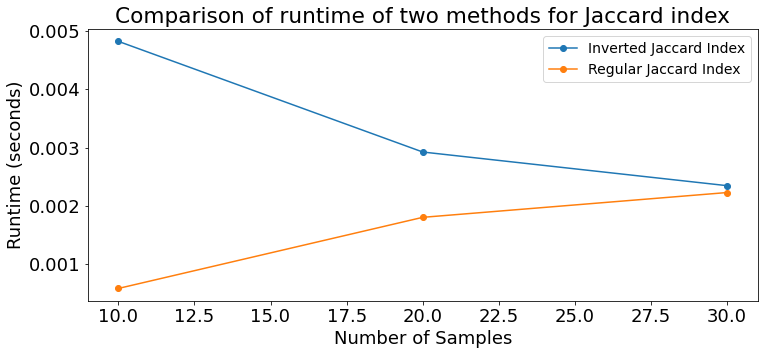

In [26]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 18,
    'legend.fontsize': 14
})

def make_plot(plotting_label, results_df):
    plot_df = results_df[['mean', 'label', plotting_label]].set_index([plotting_label, 'label']).unstack(-1)
    plot_df.columns = plot_df.columns.droplevel()
    plot_df.columns.name = None

    axes = plot_df.plot(kind='line', figsize=(12,5), marker='o')
    axes.set_ylabel('Runtime (seconds)')
    axes.set_title('Comparison of runtime of two methods for Jaccard index')
    return axes

make_plot(plotting_label='Number of Samples', results_df=results_df)

## Test 1: Adjusting number of samples

<AxesSubplot:title={'center':'Comparison of runtime of two methods for Jaccard index'}, xlabel='Number of Samples', ylabel='Runtime (seconds)'>

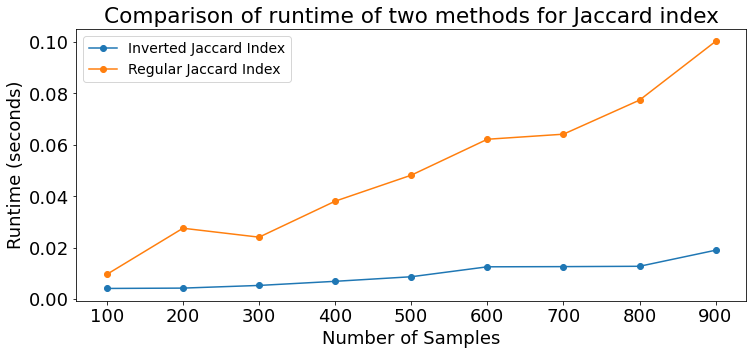

In [29]:
results_df = comparisons(samples_range=range(100,1000,100), hashes_range=[1000], fixed_hashes_range=[0])
make_plot(plotting_label='Number of Samples', results_df=results_df)

# Test 2: Adjust number of hashes

<AxesSubplot:title={'center':'Comparison of runtime of two methods for Jaccard index'}, xlabel='Number of hashes', ylabel='Runtime (seconds)'>

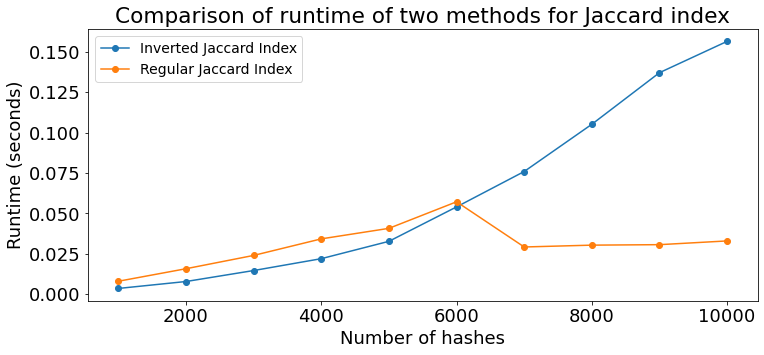

In [17]:
results_df = comparisons(samples_range=[100], hashes_range=range(1000,11000,1000), fixed_hashes_range=[0])
make_plot(plotting_label='Number of hashes', results_df=results_df)

# Test 3: Adjust number of fixed hash values

<AxesSubplot:title={'center':'Comparison of runtime of two methods for Jaccard index'}, xlabel='Number of fixed hashes', ylabel='Runtime (seconds)'>

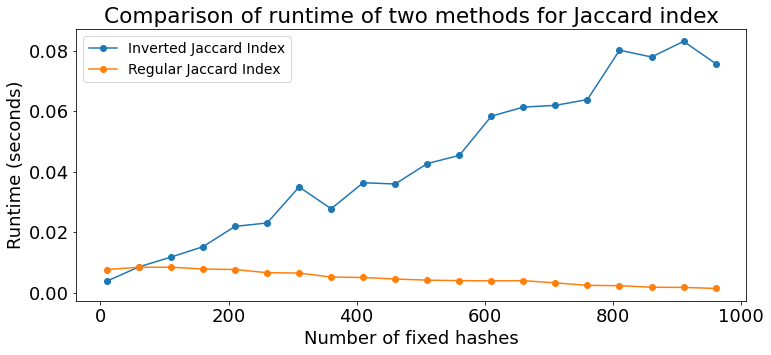

In [18]:
results_df = comparisons(samples_range=[100], hashes_range=[1000], fixed_hashes_range=range(10,1000,50))
make_plot(plotting_label='Number of fixed hashes', results_df=results_df)

# Test 4: Adjust number of samples, but with some fixed hashes

<AxesSubplot:title={'center':'Comparison of runtime of two methods for Jaccard index'}, xlabel='Number of Samples', ylabel='Runtime (seconds)'>

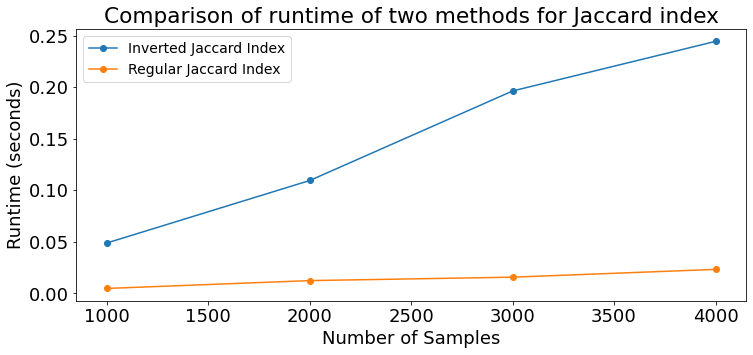

In [40]:
results_df = comparisons(samples_range=range(1000,5000,1000), hashes_range=[1000], fixed_hashes_range=[500], iterations=1, repeat=1)
make_plot(plotting_label='Number of Samples', results_df=results_df)